## Libraries

In [3]:
import numpy as np
import pandas as pd

from Jcb import calc_basis_matrix
from cordex_discrete import cordex_discrete
from cordex_continuous import cordex_continuous
from plot_fun import subplot_results
from bayesian_opt import bo_loop

## Settings

In [4]:
runs = 4
levels = np.linspace(-1,1,3).tolist()
epochs = 1_000
optimality = 'D'
method = 'Nelder-Mead'
J_cb = calc_basis_matrix(x_basis=100, b_basis=2)

## Discrete Version

In [21]:
results, best_cr = cordex_discrete(runs=runs,
                                   feats=J_cb.shape[0],
                                   levels=levels,
                                   epochs=epochs,
                                   J_cb=J_cb,
                                   optimality=optimality)
print(f"Best criterion {best_cr} for optimality {optimality}")

100%|██████████| 1000/1000 [00:06<00:00, 158.01it/s]

Best criterion 0.9996500599999999 for optimality D


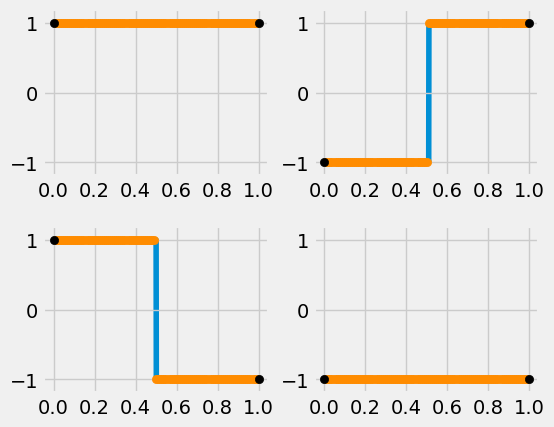

In [22]:
subplot_results(sub_x=2, sub_y=2, T=np.linspace(0, 1, 1000), results=results, J_cb=J_cb)

## Continuous Version

In [23]:
# Nelder-Mead, L-BFGS-B, Powell, TNC
results, best_cr = cordex_continuous(runs=runs,
                                     feats=J_cb.shape[0],
                                     J_cb=J_cb,
                                     epochs=epochs,
                                     method=method,
                                     optimality=optimality)
print(f"Best criterion {best_cr} for optimality {optimality}")

100%|██████████| 1000/1000 [01:53<00:00,  8.80it/s]

Best criterion 0.9968548599999982 for optimality D


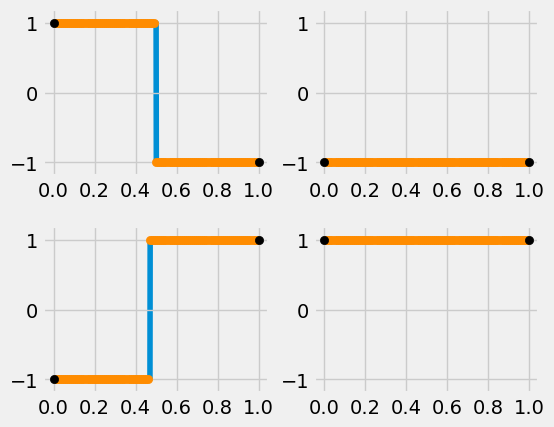

In [24]:
subplot_results(sub_x=2, sub_y=2, T=np.linspace(0, 1, 1000), results=results, J_cb=J_cb)

## Bayesian Optimization

In [ ]:
# TODO: We still have a problem when calculating optimalities other than D
results, best_cr = bo_loop(epochs=500,
                           runs=runs,
                           feats=J_cb.shape[0],
                           optimality=optimality,
                           initialization_method=method,
                           J_cb=J_cb)
print(f"Best criterion {best_cr} for optimality {optimality}")

100%|██████████| 10/10 [01:54<00:00, 11.40s/it]


[1.57199251e-05]
-0.0


 39%|███▉      | 194/500 [06:14<10:30,  2.06s/it]

In [ ]:
subplot_results(sub_x=2, sub_y=2, T=np.linspace(0, 1, 1000), results=results, J_cb=J_cb)

## Comparissons with Literature

In [ ]:
literature = np.array([
    [2, 2, 4, 8.750],
    [2, 3, 4, 8.828],
    [2, 4, 4, 8.750],
    [2, 8, 4, 8.493],
    [2, 16, 4, 8.427],
    [2, 100, 4, 8.404],
    [2, 2, 8, 3.958],
    [2, 3, 8, 4.287],
    [2, 4, 8, 3.903],
    [2, 8, 8, 3.902],
    [2, 16, 8, 3.887],
    [2, 100, 8, 3.882],
    [2, 2, 12, 2.583],
    [2, 3, 12, 2.778],
    [2, 4, 12, 2.570],
    [2, 8, 12, 2.539],
    [2, 16, 12, 2.520],
    [2, 100, 12, 2.512],
    [3, 3, 4, 386.408],
    [3, 4, 4, 246.869],
    [3, 8, 4, 218.479],
    [3, 16, 4, 208.843],
    [3, 100, 4, 206.884],
    [3, 3, 8, 189.766],
    [3, 4, 8, 103.553],
    [3, 8, 8, 99.109],
    [3, 16, 8, 97.408],
    [3, 100, 8, 96.709],
    [3, 3, 12, 126.409],
    [3, 4, 12, 67.735],
    [3, 8, 12, 65.217],
    [3, 16, 12, 63.610],
    [3, 100, 12, 63.028],

])

In [ ]:
discrete_output_linear = []
for n_b in [2]:
    for run in [4,8,12]:
        for n_x in [2,3,4,8,16,100]:
            J_cb = calc_basis_matrix(x_basis=n_x, b_basis=n_b)
            _, best_cr = cordex_discrete(runs=run,
                                               feats=J_cb.shape[0],
                                               levels=[-1,0,1],
                                               epochs=1000,
                                               J_cb=J_cb,
                                               optimality='A')
            discrete_output_linear.append(np.round(best_cr,3))

discrete_output_quadratic = []
for n_b in [3]:
    for run in [4,8,12]:
        for n_x in [3,4,8,16,100]:
            J_cb = calc_basis_matrix(x_basis=n_x, b_basis=n_b)
            _, best_cr = cordex_discrete(runs=run,
                                         feats=J_cb.shape[0],
                                         levels=[-1,0,1],
                                         epochs=1000,
                                         J_cb=J_cb,
                                         optimality='A')
            discrete_output_quadratic.append(np.round(best_cr,3))

In [ ]:
discrete_output_linear.extend(discrete_output_quadratic)
discrete_output = discrete_output_linear.copy()

In [ ]:
continuous_output_linear_nm = []
for n_b in [2]:
    for run in [4,8,12]:
        for n_x in [2,3,4,8,16,100]:
            J_cb = calc_basis_matrix(x_basis=n_x, b_basis=n_b)
            _, best_cr = cordex_continuous(runs=run,
                                           feats=J_cb.shape[0],
                                           J_cb=J_cb,
                                           epochs=1000,
                                           method='Nelder-Mead',
                                           optimality='A')
            continuous_output_linear_nm.append(np.round(best_cr,3))
print("---")
continuous_output_quadratic_nm = []
for n_b in [3]:
    for run in [4,8,12]:
        for n_x in [3,4,8,16,100]:
            J_cb = calc_basis_matrix(x_basis=n_x, b_basis=n_b)
            _, best_cr = cordex_continuous(runs=run,
                                           feats=J_cb.shape[0],
                                           J_cb=J_cb,
                                           epochs=1000,
                                           method='Nelder-Mead',
                                           optimality='A')
            continuous_output_quadratic_nm.append(np.round(best_cr,3))

In [ ]:
continuous_output_linear_nm.extend(continuous_output_quadratic_nm)
continuous_output_nm = np.array(continuous_output_linear_nm.copy()).reshape(-1,1)

In [ ]:
continuous_output_linear_p = []
for n_b in [2]:
    for run in [4,8,12]:
        for n_x in [2,3,4,8,16,100]:
            J_cb = calc_basis_matrix(x_basis=n_x, b_basis=n_b)
            _, best_cr = cordex_continuous(runs=run,
                                           feats=J_cb.shape[0],
                                           J_cb=J_cb,
                                           epochs=1000,
                                           method='Powell',
                                           optimality='A')
            continuous_output_linear_p.append(np.round(best_cr,3))
print("---")
continuous_output_quadratic_p = []
for n_b in [3]:
    for run in [4,8,12]:
        for n_x in [3,4,8,16,100]:
            J_cb = calc_basis_matrix(x_basis=n_x, b_basis=n_b)
            _, best_cr = cordex_continuous(runs=run,
                                           feats=J_cb.shape[0],
                                           J_cb=J_cb,
                                           epochs=1000,
                                           method='Powell',
                                           optimality='A')
            continuous_output_quadratic_p.append(np.round(best_cr,3))

In [ ]:
continuous_output_linear_p.extend(continuous_output_quadratic_p)
continuous_output_p = np.array(continuous_output_linear_p.copy()).reshape(-1,1)

In [ ]:
continuous_output_linear_bfgs = []
for n_b in [2]:
    for run in [4,8,12]:
        for n_x in [2,3,4,8,16,100]:
            J_cb = calc_basis_matrix(x_basis=n_x, b_basis=n_b)
            _, best_cr = cordex_continuous(runs=run,
                                           feats=J_cb.shape[0],
                                           J_cb=J_cb,
                                           epochs=1000,
                                           method='L-BFGS-B',
                                           optimality='A')
            continuous_output_linear_bfgs.append(np.round(best_cr,3))
print("---")
continuous_output_quadratic_bfgs = []
for n_b in [3]:
    for run in [4,8,12]:
        for n_x in [3,4,8,16,100]:
            J_cb = calc_basis_matrix(x_basis=n_x, b_basis=n_b)
            _, best_cr = cordex_continuous(runs=run,
                                           feats=J_cb.shape[0],
                                           J_cb=J_cb,
                                           epochs=1000,
                                           method='L-BFGS-B',
                                           optimality='A')
            continuous_output_quadratic_bfgs.append(np.round(best_cr,3))

In [ ]:
continuous_output_linear_bfgs.extend(continuous_output_quadratic_bfgs)
continuous_output_bfgs = np.array(continuous_output_linear_bfgs.copy()).reshape(-1,1)

In [ ]:
continuous_output_linear_tnc = []
for n_b in [2]:
    for run in [4,8,12]:
        for n_x in [2,3,4,8,16,100]:
            J_cb = calc_basis_matrix(x_basis=n_x, b_basis=n_b)
            _, best_cr = cordex_continuous(runs=run,
                                           feats=J_cb.shape[0],
                                           J_cb=J_cb,
                                           epochs=1000,
                                           method='TNC',
                                           optimality='A')
            continuous_output_linear_tnc.append(np.round(best_cr,3))
print("---")
continuous_output_quadratic_tnc = []
for n_b in [3]:
    for run in [4,8,12]:
        for n_x in [3,4,8,16,100]:
            J_cb = calc_basis_matrix(x_basis=n_x, b_basis=n_b)
            _, best_cr = cordex_continuous(runs=run,
                                           feats=J_cb.shape[0],
                                           J_cb=J_cb,
                                           epochs=1000,
                                           method='TNC',
                                           optimality='A')
            continuous_output_quadratic_tnc.append(np.round(best_cr,3))

In [ ]:
continuous_output_linear_tnc.extend(continuous_output_quadratic_tnc)
continuous_output_tnc = np.array(continuous_output_linear_tnc.copy()).reshape(-1,1)

In [ ]:
bo_output_linear = []
for n_b in [2]:
    for run in [4,8,12]:
        for n_x in [2,3,4,8,16,100]:
            J_cb = calc_basis_matrix(x_basis=n_x, b_basis=n_b)
            _, best_cr = bo_loop(epochs=500,
                                 runs=run,
                                 feats=J_cb.shape[0],
                                 optimality='A',
                                 J_cb=J_cb)
            bo_output_linear.append(np.round(best_cr,3))
print("---")
bo_output_quadratic = []
for n_b in [3]:
    for run in [4,8,12]:
        for n_x in [3,4,8,16,100]:
            J_cb = calc_basis_matrix(x_basis=n_x, b_basis=n_b)
            _, best_cr = bo_loop(epochs=500,
                                 runs=run,
                                 feats=J_cb.shape[0],
                                 optimality='A',
                                 J_cb=J_cb)
            bo_output_quadratic.append(np.round(best_cr,3))

In [ ]:
bo_output_linear.extend(bo_output_quadratic)
bo_output = np.array(bo_output_linear.copy()).reshape(-1,1)

In [ ]:
Final = np.round(np.concatenate((literature, continuous_output_nm, continuous_output_bfgs, continuous_output_p, continuous_output_tnc, bo_output), axis=1),3)
nm_diff = np.round(np.abs(Final[:,3] - Final[:,4]),3).reshape(-1,1)
bfgs_diff = np.round(np.abs(Final[:,3] - Final[:,5]),3).reshape(-1,1)
p_diff = np.round(np.abs(Final[:,3] - Final[:,6]),3).reshape(-1,1)
tnc_diff = np.round(np.abs(Final[:,3] - Final[:,7]),3).reshape(-1,1)
bo_diff = np.round(np.abs(Final[:,3] - Final[:,8]),3).reshape(-1,1)

Final = np.concatenate((Final, nm_diff, bfgs_diff, p_diff, tnc_diff, bo_diff), axis=1)
Final

In [ ]:
Final_df = pd.DataFrame(Final, columns=['n_b',
                                        'n_x',
                                        'n',
                                        'Michaelidis',
                                        'Nelder-Mead',
                                        'L-BFGS-B',
                                        'Powell',
                                        'TNC',
                                        '|Nelder-Mead diff|',
                                        '|L-BFGS-B diff|',
                                        '|Powell diff|',
                                        '|TNC diff|',
                                        '|BO diff|'])
Final_df.to_csv("Comparisson.csv")

## Testing output

In [ ]:
n_x = 16
n_b = 3
runs = 4
epochs = 1000
method='Nealder-Mead'
optimality = 'A'

In [ ]:
J_cb = calc_basis_matrix(x_basis=n_x, b_basis=n_b)
res, best_cr = cordex_continuous(runs=runs,
                               feats=J_cb.shape[0],
                               J_cb=J_cb,
                               epochs=epochs,
                               method=method,
                               optimality=optimality)
subplot_results(sub_x=2, sub_y=2, T=np.linspace(0, 1, 1000), results=res, J_cb=J_cb)

In [ ]:
best_cr